# Projeto 3 - Supercomputação
# TSP GPU
### Lucas Chen Alba

## Descrição do problema

Este projeto consiste em realizar simulações do conhecido problema do caixeiro-viajante (https://en.wikipedia.org/wiki/Travelling_salesman_problem) e analisar o ganho de velocidade com a utilização de técnicas de computação paralela e otimizações. A simulação consiste em encontrar o caminho ótimo ou sub-ótimo para um dado número de nós na rede do caxeiro.
A técnica usada é a de montar sequências aleatórias e selecionar a melhor dentre elas

## Medições de tempo

Para as medições do tempo gasto nas simulações foi utilizada a biblioteca _chrono_ para CPU e a biblioteca nativa do CUDA para GPU.

A simulação utiliza-se de duas configurações de _flags_ de compilação distintas:

__-O3__ (para GPU)

__-O3 -fopenmp__ (para CPU)

## Organização geral do código

### Local Search (CPU)
Para a otimização discreta "Local Search" foram implementadas duas novas funções:

__void local_search(std::vector<std::vector<double>> points, double &best_cost, std::vector<std::vector<double>> &best_sol)__: Esta função irá receber um caminho aleatório e irá otimizá-lo até chegar em uma solução sub-ótima, significando um mínimo local. Ela faz isso a partir da checagem de "cruzamentos" entre dois pares de pontos quaisquer do caminho, ela então realiza um "swap" dos pontos, assim, quando todos os cruzamentos forem resolvidos, este será o mínimo local.
    
__bool check_intersec(std::vector<double> p1, std::vector<double> p2, std::vector<double> q1, std::vector<double> q2)__: Esta função recebe uma sequência de 4 pontos e checa se há alguma interseção entre os segmentos de reta formados pelos dois pares de pontos.

Na função _main()_ serão gerados 10000 caminhos aleatórios, caminhos estes que serão passados para chamadas da função local_search(), este número define a quantidade de caminhos iniciais aleatórios seráo otimizados pelo Local Search.

### Random (GPU, CUDA)
Este código realiza a divisão de tarefas em "kernels". Inicialmente são pré-calculadas as distâncias entre os nós da rede. Essas distâncias são então guardadas em um vetor __device__ (memória global da GPU).

Assim, podemos criar um kernel para cada caminho aleatório. Foram criados 10000 kernels, cada um realizando então um "shuffle" nos caminhos, guardando a respectiva sequência e a distância (calculada a partir do vetor de distâncias) total em um outro vetor __device__. Assim, conseguimos utilizar a função da biblioteca thrust (thrust::min_element) para localizar o índice do menos caminho.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Simulation times')

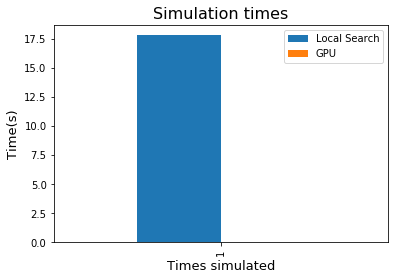

In [6]:
# Mean times
groups = [[17.82, 0.010]]
group_labels = ['1']

# Convert data to pandas DataFrame.
df = pd.DataFrame(groups, index=group_labels).T

# Plot
pd.concat(
    [df.loc[0].rename('Local Search'),
     df.loc[1].rename('GPU')],
    axis=1).plot.bar()
plt.xlabel('Times simulated', fontsize=13)
plt.ylabel('Time(s)', fontsize=13)
plt.title('Simulation times', fontsize=16)

## Resultados e análises

Percebemos um alto ganho no desempenho quando comparamos a versão CPU com a GPU. Isso se deve ao fato da GPU possuir muitos kernels que realizam as terefas simultaneamente, enquante na CPU (Local Search) cada task realiza também as tarefas em paralelo, porém é necessário um bloco de código inserido em uma região crítica (#pragma omp critical), para evitar escritas simultâneas na memória.